# Extracting Tweets for all stocks and Sentiment Analysis
---

We have cleaned datasets from different posts to proceed with the following processes:

- Import Datasets and create a single dataset.
- Feature extraction.
- Remove characters, Tokenize and Lemmatize
- Sentiment Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import datetime as dt

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Import tweets' datasets

In [2]:
## Import tweets' datasets
stock_news = pd.read_csv('datasets/us_equities_news_dataset.csv', index_col=False)

In [3]:
stock_news.head()

,id,ticker,title,category,content,release_date,provider,url,article_id
0,221515,NIO,Why Shares of Chinese Electric Car Maker NIO A...,news,What s happening\nShares of Chinese electric c...,2020-01-15,The Motley Fool,https://invst.ly/pigqi,2060327
1,221516,NIO,NIO only consumer gainer Workhorse Group amon...,news,Gainers NIO NYSE NIO 7 \nLosers MGP Ingr...,2020-01-18,Seeking Alpha,https://invst.ly/pje9c,2062196
2,221517,NIO,NIO leads consumer gainers Beyond Meat and Ma...,news,Gainers NIO NYSE NIO 14 Village Farms In...,2020-01-15,Seeking Alpha,https://invst.ly/pifmv,2060249
3,221518,NIO,NIO NVAX among premarket gainers,news,Cemtrex NASDAQ CETX 85 after FY results \n...,2020-01-15,Seeking Alpha,https://invst.ly/picu8,2060039
4,221519,NIO,PLUG NIO among premarket gainers,news,aTyr Pharma NASDAQ LIFE 63 on Kyorin Pharm...,2020-01-06,Seeking Alpha,https://seekingalpha.com/news/3529772-plug-nio...,2053096


In [4]:
stock_news.shape

(221513, 9)

In [5]:
aapl_news = stock_news[stock_news['ticker'] == 'AAPL'].copy()

In [6]:
aapl_news.shape

(20231, 9)

In [7]:
aapl_news.dtypes

id               int64
ticker          object
title           object
category        object
content         object
release_date    object
provider        object
url             object
article_id       int64
dtype: object

In [8]:
aapl_news.drop(columns=['id','ticker','url', 'article_id'], inplace=True)

In [9]:
aapl_news.head(3)

,title,category,content,release_date,provider
49183,JPMorgan cautious ahead of Apple earnings,news,JPMorgan lifts its Apple AAPL 2 9 target f...,2020-01-28,Seeking Alpha
49184,FAANG s Fall but Get Some Wall Street Love,news,By Kim Khan \nInvesting com The FAANG stocks...,2020-01-28,Investing.com
49185,Wall Street tumbles as virus fuels economic worry,news,By Chuck Mikolajczak NEW YORK Reuters U S ...,2020-01-28,Reuters


In [10]:
aapl_news.reset_index(inplace=True)
aapl_news.drop('index', axis=1, inplace=True)

In [11]:
aapl_news.tail(3)

,title,category,content,release_date,provider
20228,Summer Heat Scorches Europe And U S,opinion,Europe flares as summer heat continues Summer...,2012-07-23,John Nyaradi
20229,Apple Earnings Preview Quarterly Dip On Deck,opinion,Last quarter Apple AAPL reported the 2nd bes...,2012-07-23,David Dyer
20230,Trade Apple After Earnings,opinion,It may look like a spider web but the mishmas...,2012-07-23,Abigail Doolittle


In [12]:
aapl_news.groupby('provider')[['content']].count().sort_values(by='content', ascending=False)

,content
provider,
Zacks Investment Research,9119
Reuters,4136
Investing.com,1031
Seeking Alpha,892
Dr. Duru,222
...,...
Nick Mastrandrea,1
Gary Dorsch,1
CMTrading,1


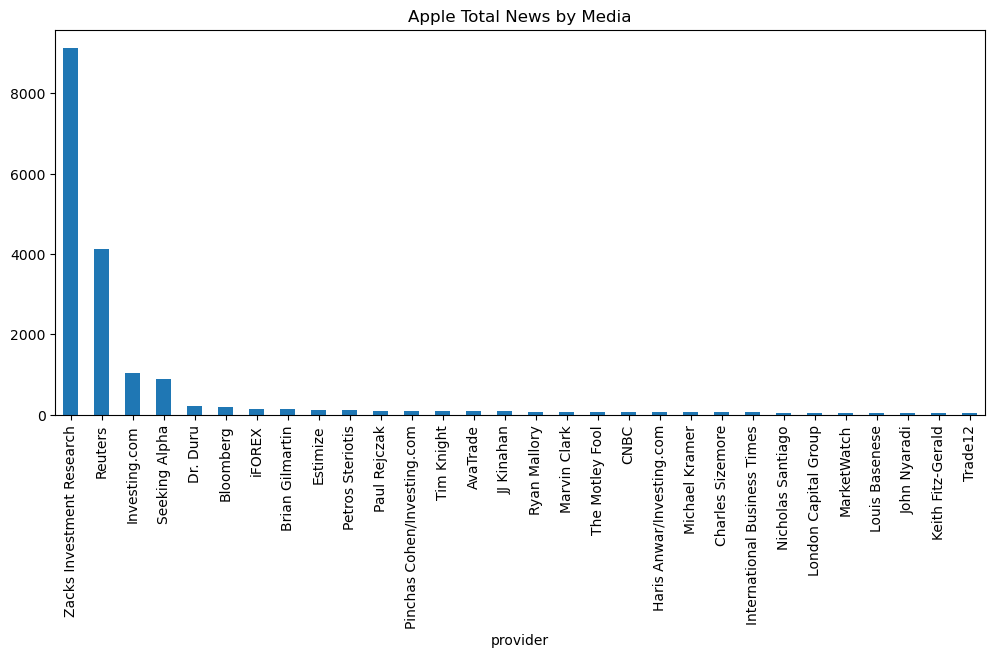

In [13]:
aapl_news.groupby('provider')['provider'].count().sort_values(ascending=False)[:30].plot(kind='bar', title='Apple Total News by Media', figsize=(12,5));

## Pre-Processing and Exploration
---

The followings are the steps taken to pre-process text data. 

1. Remove special characters & pre-processing the text data
3. Tokenizing
4. Lemmatizing
5. Stop word removal
6. Removing special characters & Tokenizing

### Remove special characters & pre-processing the text data

In [14]:
sample_p = 2
for i in range(sample_p):
    print(aapl_news['content'][i])

JPMorgan lifts its Apple  AAPL  2 9   target from  296 to  300 ahead of tomorrow s earnings report 
Analyst Samik Chatterjee expects an upside quarter driven by better than expected Apple Watch and AirPods sales 
The analyst expects  88 7B in revenue with  49 7B coming from the iPhone   12 9B from Services  and  11 6B from Wearables 
Chatterjee continues to recommend Apple for long term holders but is wary of the  high bar of investor expectations  heading into earnings 
Apple has a Bullish average Sell Side rating 
By Kim Khan 
Investing com   The FAANG stocks were predictably struggling Monday as money flew out from risk assets 
The tech stalwarts are enjoying high valuations and earnings are coming  with Apple  NASDAQ AAPL   Amazon  NASDAQ AMZN  and Facebook  NASDAQ FB  issuing numbers this week and Google parent Alphabet  NASDAQ GOOGL  up next week 
Wall Street analysts are taking this time to get their ducks in a row before the reports 
Mizuho boosted its target on Alphabet  NASDA

In [15]:
def scrub_clean(text):

    # Initatiate tokenizer & Lemmatizer
    tokenizer = RegexpTokenizer('\w+')
    lemmatizer = WordNetLemmatizer()

    # Tokenizing sentences.
    tokenized = tokenizer.tokenize(str(text).lower())
    #print('CHeck token ', tokenized)
    
    # Lemmatization each word back to simplest form (Normalizing words.). 
    tokens_lem = [lemmatizer.lemmatize(token) for token in tokenized]
    
    # Removal of common words
    stopword = stopwords.words('english')
    notstopword = [word for word in tokens_lem if word not in stopword]
    
    #stop = stopwords.filtered_post('english')
    
    # Return join cleaned sentence
    return(' '.join(notstopword))

In [16]:
# Add word counts for each row
aapl_news['Word_counts'] = aapl_news['content'].apply(lambda x: len(str(x).split(' ')))

In [17]:
### Removing special characters & Tokenizing
aapl_news['content'] = aapl_news['content'].map(scrub_clean)

#### Sentiment Analysis

Here is to analyze the data to determine whether the post and title sentiments are positive, negative or neutral using NLP.

In [18]:
# Instantiate Sentiment Intensity Analyzer
sentiment = SentimentIntensityAnalyzer()

In [19]:
# get sentiment score 

def sent_score(df, col):
    
    # Initialize empty list
    sentiment_score = []

    for i, data in df.iterrows():
    
        # Get joined score for both title and post 
        scores = sentiment.polarity_scores(data[col])
        sentiment_score.append(scores)
    
    sent_df = pd.DataFrame(sentiment_score)
    return sent_df

In [20]:
aapl_sent = sent_score(aapl_news, 'content')

In [21]:
aapl_sent.head()

,neg,neu,pos,compound
0,0.000,0.880,0.120,0.7783
1,0.068,0.704,0.228,0.9786
2,0.140,0.779,0.081,-0.9825
3,0.065,0.793,0.142,0.9929
4,0.026,0.743,0.231,0.9973


In [22]:
aapl_sent.shape

(20231, 4)

In [23]:
# Verify score with the tweets
aapl_news.head()

,title,category,content,release_date,provider,Word_counts
0,JPMorgan cautious ahead of Apple earnings,news,jpmorgan lift apple aapl 2 9 target 296 300 ah...,2020-01-28,Seeking Alpha,103
1,FAANG s Fall but Get Some Wall Street Love,news,kim khan investing com faang stock predictably...,2020-01-28,Investing.com,292
2,Wall Street tumbles as virus fuels economic worry,news,chuck mikolajczak new york reuters u stock suf...,2020-01-28,Reuters,867
3,Earnings Watch Apple and AMD to take earnings...,news,two best performing tech stock 2019 set report...,2020-01-28,MarketWatch,6033
4,Day Ahead Top 3 Things to Watch for Jan 28,news,yasin ebrahim kim khan 1 apple ready earnings ...,2020-01-28,Investing.com,629


In [24]:
# Copy df with sentiment dataframe
aapl_news_sent = pd.concat([aapl_news, aapl_sent.set_index(aapl_news.index)], axis=1)

In [25]:
aapl_news_sent.head()

,title,category,content,release_date,provider,Word_counts,neg,neu,pos,compound
0,JPMorgan cautious ahead of Apple earnings,news,jpmorgan lift apple aapl 2 9 target 296 300 ah...,2020-01-28,Seeking Alpha,103,0.000,0.880,0.120,0.7783
1,FAANG s Fall but Get Some Wall Street Love,news,kim khan investing com faang stock predictably...,2020-01-28,Investing.com,292,0.068,0.704,0.228,0.9786
2,Wall Street tumbles as virus fuels economic worry,news,chuck mikolajczak new york reuters u stock suf...,2020-01-28,Reuters,867,0.140,0.779,0.081,-0.9825
3,Earnings Watch Apple and AMD to take earnings...,news,two best performing tech stock 2019 set report...,2020-01-28,MarketWatch,6033,0.065,0.793,0.142,0.9929
4,Day Ahead Top 3 Things to Watch for Jan 28,news,yasin ebrahim kim khan 1 apple ready earnings ...,2020-01-28,Investing.com,629,0.026,0.743,0.231,0.9973


In [26]:
aapl_news_sent[['neg','neu','pos','compound']].describe()

,neg,neu,pos,compound
count,20231.000000,20231.000000,20231.000000,20231.000000
mean,0.057677,0.764841,0.177483,0.784924
std,0.042945,0.061536,0.062678,0.494684
min,0.000000,0.311000,0.000000,-0.999100
25%,0.025000,0.725000,0.135000,0.923100
50%,0.049000,0.762000,0.176000,0.990100
75%,0.082000,0.802000,0.219000,0.997200
max,0.372000,1.000000,0.536000,1.000000


In [27]:
aapl_news_sent.set_index('release_date')

,title,category,content,provider,Word_counts,neg,neu,pos,compound
release_date,,,,,,,,,
2020-01-28,JPMorgan cautious ahead of Apple earnings,news,jpmorgan lift apple aapl 2 9 target 296 300 ah...,Seeking Alpha,103,0.000,0.880,0.120,0.7783
2020-01-28,FAANG s Fall but Get Some Wall Street Love,news,kim khan investing com faang stock predictably...,Investing.com,292,0.068,0.704,0.228,0.9786
2020-01-28,Wall Street tumbles as virus fuels economic worry,news,chuck mikolajczak new york reuters u stock suf...,Reuters,867,0.140,0.779,0.081,-0.9825
2020-01-28,Earnings Watch Apple and AMD to take earnings...,news,two best performing tech stock 2019 set report...,MarketWatch,6033,0.065,0.793,0.142,0.9929
2020-01-28,Day Ahead Top 3 Things to Watch for Jan 28,news,yasin ebrahim kim khan 1 apple ready earnings ...,Investing.com,629,0.026,0.743,0.231,0.9973
...,...,...,...,...,...,...,...,...,...
2012-07-16,Waiting For Direction On The Markets,opinion,stock market ha difficult one trader investor ...,Cam Hui,1288,0.107,0.756,0.137,0.9463
2012-07-19,Mid Year Update U S And Canadian Stock Marke...,opinion,2004 2010 tsx 300 index leading canadian stock...,Baskin Financial Blog,1602,0.084,0.743,0.173,0.9978
2012-07-23,Summer Heat Scorches Europe And U S,opinion,europe flare summer heat continues summer heat...,John Nyaradi,648,0.078,0.832,0.090,0.3818


In [28]:
aapl_news_sent['release_date'].describe()

count          20231
unique          2267
top       2019-11-04
freq             116
Name: release_date, dtype: object

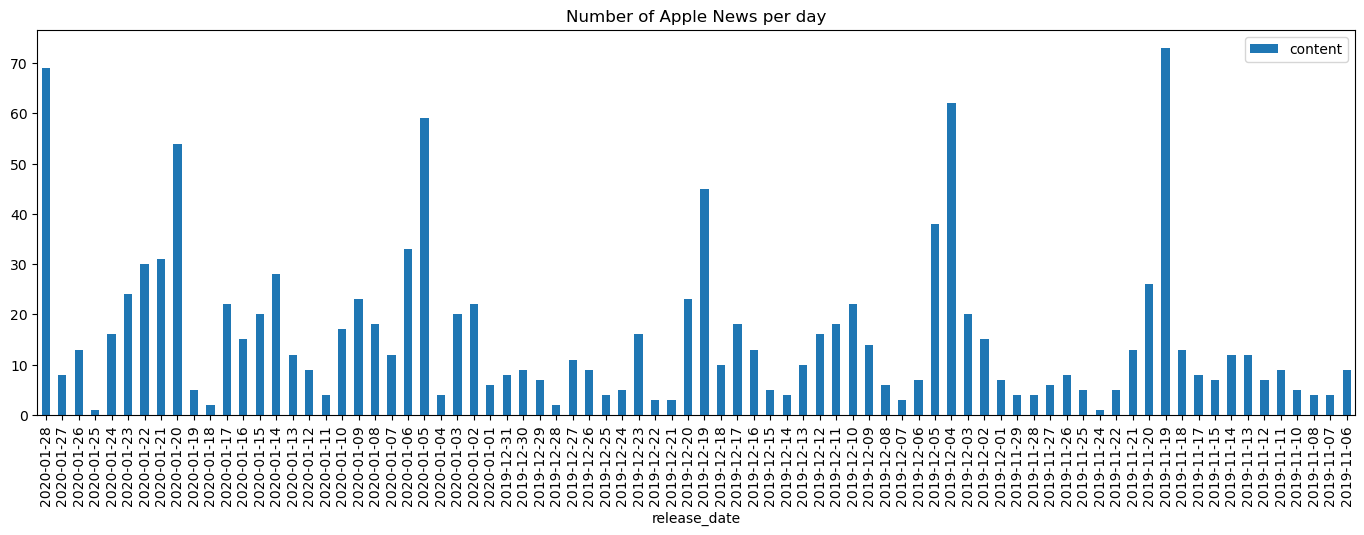

In [29]:
aapl_news_sent.groupby('release_date')[['content']].count().sort_values(by='release_date', ascending=False)[:80].plot(kind='bar', figsize=(17,5))
plt.title('Number of Apple News per day')
plt.show();

#### Frequent used wodescribe

In [30]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer(analyzer = "word",
                      stop_words = 'english')

In [31]:
# Countvectorize the tweets

def count_vect(df, col):
    # convert training data to dataframe
    df_tweet= pd.DataFrame(
    cvec.fit_transform(df[col]).todense(),
        columns=cvec.get_feature_names_out()
    )

    # plot top occuring words
    df_tweet.sum().sort_values(ascending=False).head(10).plot(kind='barh');
    return df_tweet

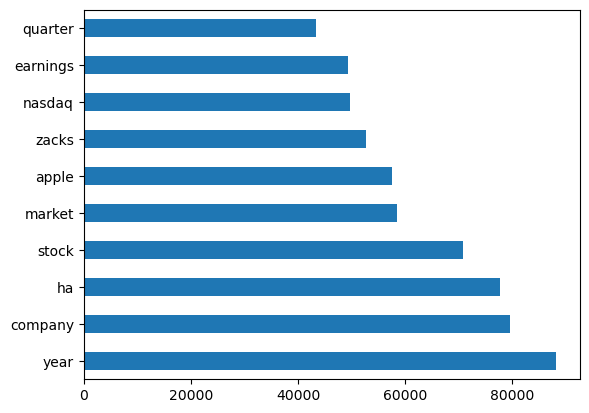

In [32]:
# Get Apple's countvectorize tweets
aapl_cvec = count_vect(aapl_news, 'content')

In [33]:
aapl_byday_comp_sent = pd.DataFrame(aapl_news_sent.groupby('release_date')[['compound']].mean())

In [34]:
aapl_byday_comp_sent.head(2)

,compound
release_date,
2012-07-16,0.9463
2012-07-19,0.9978


In [35]:
aapl_byday_comp_sent.tail(2)

,compound
release_date,
2020-01-27,0.737588
2020-01-28,0.575671


In [36]:
aapl_byday_comp_sent.sort_index(ascending=False, inplace=True)

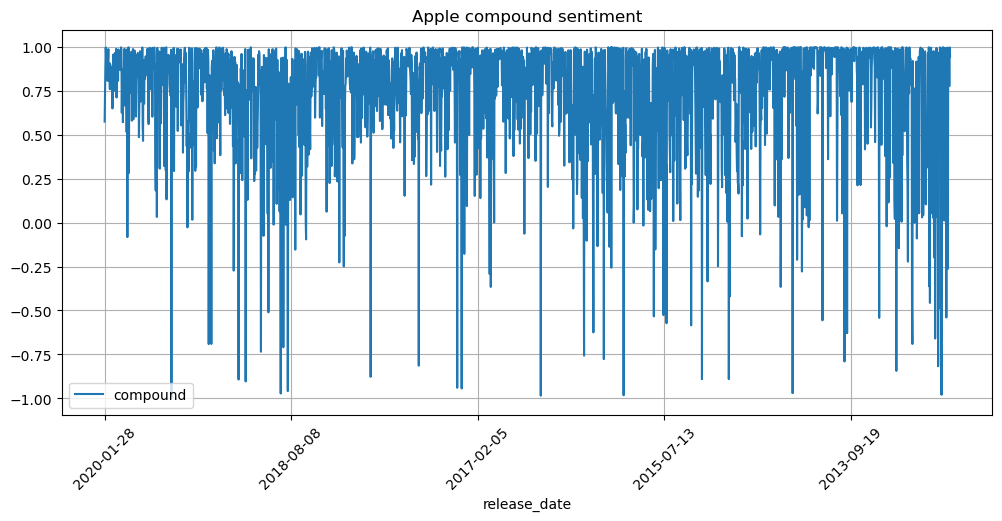

In [37]:
aapl_byday_comp_sent.plot(y = 'compound', kind='line', title='Apple compound sentiment', figsize=(12,5), grid=True)
plt.xticks(rotation=45);

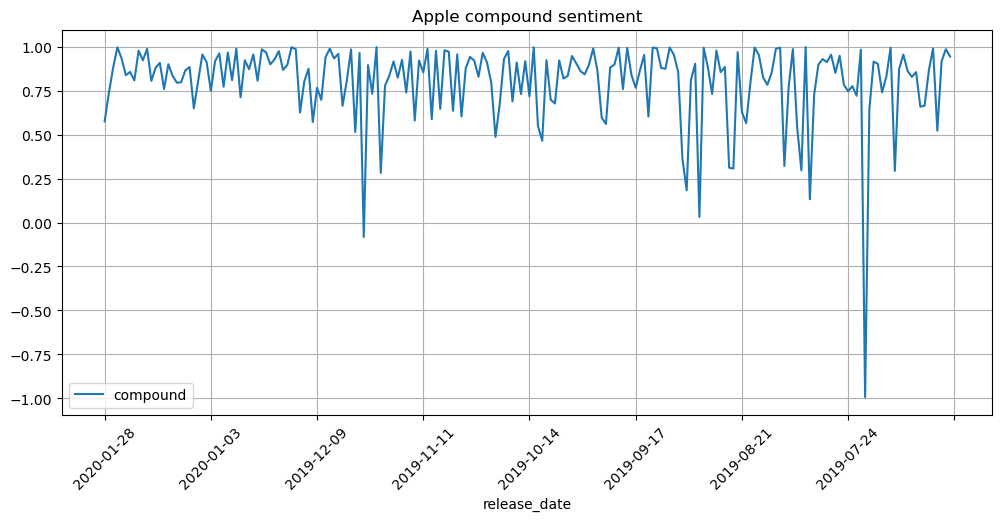

In [38]:
aapl_byday_comp_sent[:200].plot(y = 'compound', kind='line', title='Apple compound sentiment', figsize=(12,5), grid=True)
plt.xticks(rotation=45);

In [39]:
aapl_byday_comp_sent[aapl_byday_comp_sent['compound'] < 0]

,compound
release_date,
2019-11-27,-0.082350
2019-07-20,-0.993300
2019-06-02,-0.026750
2019-03-30,-0.691500
2019-03-23,-0.690800
...,...
2012-09-25,-0.817600
2012-09-12,-0.492333
2012-09-06,-0.980300


In [44]:
aapl_news[(aapl_news['release_date'] < '2019-07-24') & (aapl_news['release_date'] > '2019-07-17')]

,title,category,content,release_date,provider,Word_counts
1890,South Korean firm to boost output of chipmakin...,news,seoul reuters south korean maker chemical used...,2019-07-23,Reuters,273
1893,U S justice department to open new antitrust ...,news,reuters u justice department opening broad ant...,2019-07-23,Reuters,121
1898,Most of 34 victims in Kyoto Animation arson at...,news,tim kelly sam nussey kyoto japan reuters many ...,2019-07-20,Reuters,894
1899,Economic Calendar Top 5 Things to Watch This...,news,investing com european central bank policy mee...,2019-07-21,Investing.com,843
1900,LG Display says to invest 2 6 billion in OLED...,news,seoul reuters lg display said tuesday would in...,2019-07-22,Reuters,139
...,...,...,...,...,...,...
3605,Can Product Strength Aid Texas Instruments TX...,opinion,texas instrument nasdaq txn ti scheduled repor...,2019-07-18,Zacks Investment Research,637
3607,Union Pacific UNP Q2 Earnings Top Rise Y Y...,opinion,united pacific corporation nyse unp second qua...,2019-07-18,Zacks Investment Research,722
3608,Can IHeartMedia Rise Out Of The Chapter 11 Ashes,opinion,iheartmedia 1 audio medium company u ha emerge...,2019-07-18,Zacks Investment Research,996
3610,3 Key Takeaways From J J s JNJ Q2 Earnings A...,opinion,johnson johnson nyse jnj second quarter 2019 r...,2019-07-18,Zacks Investment Research,1083


In [45]:
aapl_news['content'][1898]

'tim kelly sam nussey kyoto japan reuters many victim arson attack japanese animation studio young bright future joining april shaken company president said saturday death toll climbed 34 thursday attack kyoto animation well known television series movie wa japan worst mass killing two decade wa poignant youth victim country population among world oldest many victim attack ancient capital kyoto young woman company president hideaki hatta said joined u april eighth july gave small first bonus said people promising future lost life know say rather feeling anger word hatta said fifteen victim 20 11 30 public broadcaster nhk said six 40 one wa least 60 age latest victim man died hospital wa known name victim disclosed yet wait definitive identification police confirmed identity suspect shinji aoba ex convict shop robbery formally arrested treated heavy burn unusual police release suspect name making arrest plagiarism claim aoba life modest two floor apartment building 500 km 310 mile kyoto

In [42]:
# Save cleaned data for modeling
aapl_byday_comp_sent.to_csv('datasets/aapl_sent.csv')
aapl_news.to_csv('datasets/aapl_cleaned_news_eda.csv')